In [10]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta
import calendar
import time
import matplotlib.pyplot as plt

In [3]:
# load in all files
meter_list = pd.read_csv('meter.csv')
forecast = pd.read_csv('forecast.csv')
rates = pd.read_csv('rate.csv')

# convert NaN to infity otherwise it will give me problems later
rates['aq_max_kwh'] = rates['aq_max_kwh'].fillna(float("inf"))

In [3]:
# Function I used to filter the df after merging with rates

def get_dayrates(row):
    applicable_rates = rates[(rates['exit_zone'] == row['exit_zone']) & 
                        (rates['aq_min_kwh'] <= row['aq_kwh']) & 
                        (row['aq_kwh'] <= rates['aq_max_kwh']) & 
                        (rates['date'] <= row['date'])]
    valid_rates = applicable_rates.loc[applicable_rates['date'].idxmax()]
    return valid_rates['rate_p_per_kwh']


In [4]:
'''Use pandas to calculate a transportation distribution charge for four gas meters in 
the United Kingdom. Save your code in a Jupyter notebook and upload to a public 
repo on Github (or any other platform of your choice). While solving this exercise, 
focus on efficiency - i.e., use vectorised operations and avoid loops! All data 
needed for the calculation can be found in the Excel file for this exercise. '''

# merge meter list and forecast to get all the relevant data for looking up the rates in one df - and for grouby sum later on
forecast_list = meter_list.merge(forecast, on=['meter_id'])

# initiate the function to retrieve day rates
forecast_list['rate_p_per_kwh'] = forecast_list.apply(get_dayrates, axis=1)

# calculate the daily cost and save into a new column
forecast_list['daily_cost'] = forecast_list['kwh']*forecast_list['rate_p_per_kwh']

# drop unessesairy columns
forecast_list = forecast_list.drop(['aq_kwh','exit_zone','date','rate_p_per_kwh'], axis = 1)

# sum values grouped by meter id
summary = forecast_list.groupby('meter_id').sum()

# convert to GBP and apply roundign by 2 decimal points
summary['daily_cost'] = summary['daily_cost']/100
summary = summary.round(2)

# naming convestion as was specified
summary = summary.reset_index()
summary.columns = ['Meter ID', 'Total Estimated Consumption (kWh)', 'Total Cost (£)']

print(summary)

In [4]:
'''Write a function that generates a list of random meters of any size. Examples of valid 
exit zones can be found in the rate table. You may randomly generate the annual 
quantity'''

import random 
# random

def generate_meters(length):
    df = pd.DataFrame(columns=['meter_id', 'aq_kwh', 'exit_zone'])

    # available exit zones all put into a list
    exit_zones = ['EA1', 'EA2', 'EA3', 'EA4', 'EM1', 'EM2', 'EM3', 'EM4', 'LC', 'LO', 'LS', 'LT', 'LW',
             'NE1', 'NE2', 'NE3', 'NO1', 'NO2', 'NT1', 'NT2', 'NT3', 'NW1', 'NW2', 'SC1', 'SC2',
             'SC4', 'SE1', 'SE2', 'SO1', 'SO2', 'SW1', 'SW2', 'SW3', 'WA1', 'WA2', 'WM1', 'WM2',
             'WM3']
    # make np array so I can efficiently index with a generated list
    exit_zones_np = np.array(exit_zones)
    
    # generate lists with expected or randomized values up to lenth of meter list
    meter_id_list = range(length)
    aq_list = np.random.randint(0,8000000, length)
    exit_zone_list = exit_zones_np[np.random.randint(0,37,length)]
    #combine it all zwith appropriate names
    df = pd.DataFrame({'meter_id': meter_id_list, 'aq_kwh': aq_list, 'exit_zone':exit_zone_list})
    return df


In [5]:
'''Write a function that generates mock consumption data given a list of meters and a 
start date and duration (number of days in the forecast). The data may be completely 
random and it doesn't have to match with the meters' annual quantities either'''

def consume(meter_list, start_date, duration):
    # retrieve amount of unique meters just in case
    n_meters = len(list(set(meter_list)))
    
    # multiply meters so it becomes the first column
    meter_id_col = np.tile(list(set(meter_list)), duration).tolist()
    meter_id_col.sort()
    
    # generate a datarange for every meter
    date_ranges = pd.date_range(start_date, periods=duration).tolist() * n_meters
    
    # generate conumption for every entry with correct amount of decimal points
    consumption =  np.round(np.random.uniform(0.000000, 500.000000, duration*n_meters), 6)
    
    # combine with appropriate names
    df = pd.DataFrame({'meter_id': meter_id_col, 'date': date_ranges, 'kwh': consumption})
    
    return df


In [21]:
'''Write a function that takes as an input a meter list and a consumption forecast table 
and that calculates the transportation cost table (i.e., best take your logic from task 1 
and wrap it in a function). Benchmark this function using meter lists of different sizes 
and consumption forecasts for periods of different lengths. How does the function scale 
for larger sets of data'''

# uncomment the following if you didn't load in rates for some reason
# rates = pd.read_csv('rate.csv')
# rates['aq_max_kwh'] = rates['aq_max_kwh'].fillna(float("inf"))

def calculate_transportation_cost(meter_list, forecast):
    # Start measuring time
    start_time = time.perf_counter()
    
    # make it all one table to make it easy to lookup values
    merge_start_time = time.perf_counter()
    forecast_list = meter_list.merge(forecast, on=['meter_id'])
    merge_end_time = time.perf_counter()
    print(f'Merge step took: {merge_end_time - merge_start_time:.4f} seconds')

    # Merge forecast+meterlist zith the rates where aq is between upper and lower limits and the dates makes sense
    merge_start_time = time.perf_counter()
    df = pd.merge(forecast_list, rates , on=['exit_zone'], how='left')
    merge_end_time = time.perf_counter()
    print(f'Merge with rates took: {merge_end_time - merge_start_time:.4f} seconds')

    # retrieve appropriate rates based on AQ
    filter_start_time = time.perf_counter()
    df = df[(df['aq_kwh'] >= df['aq_min_kwh']) 
                    & (df['aq_kwh'] <= df['aq_max_kwh']) 
                    & (df['date_x'] >= df['date_y'])]  
    filter_end_time = time.perf_counter()
    print(f'Filtering step took: {filter_end_time - filter_start_time:.4f} seconds')
    
    # now we may have too many entries so we only take the most recent rate based on the date column's max value per meter_id
    groupby_start_time = time.perf_counter()
    df = df.loc[df.groupby('meter_id')['date_y'].idxmax()]
    groupby_end_time = time.perf_counter()
    print(f'GroupBy and idxmax took: {groupby_end_time - groupby_start_time:.4f} seconds')

    # join the correct rates per day to the forecast_list so we can calculate
    merge_start_time = time.perf_counter()
    df = pd.merge(forecast_list, df[['meter_id', 'rate_p_per_kwh']], on='meter_id', how='left')
    merge_end_time = time.perf_counter()
    print(f'Final Merge took: {merge_end_time - merge_start_time:.4f} seconds')
    
    # classic multiplication
    calculation_start_time = time.perf_counter()
    df['daily_cost'] = df['kwh']*df['rate_p_per_kwh']
    calculation_end_time = time.perf_counter()
    print(f'Daily cost calculation took: {calculation_end_time - calculation_start_time:.4f} seconds')

    # oh shit new df just dropped (pun intended)
    summary_start_time = time.perf_counter()
    summary = df.drop(['aq_kwh','exit_zone','date','rate_p_per_kwh'], axis = 1)
    summary = summary.groupby('meter_id').sum()
    summary['daily_cost'] = summary['daily_cost']/100
    summary = summary.round(2)
    summary = summary.reset_index()
    summary.columns = ['Meter ID', 'Total Estimated Consumption (kWh)', 'Total Cost (£)']
    summary_end_time = time.perf_counter()
    print(f'Summary creation took: {summary_end_time - summary_start_time:.4f} seconds')

    # Total execution time
    end_time = time.perf_counter()
    print(f'Total execution time: {end_time - start_time:.4f} seconds')

    return summary


In [22]:
ml_lengths = [1,10,100,1000,10000]
ml_len_used = []
time_taken = []

for value in ml_lengths:
    df_ml = generate_meters(value)
    df_fc = consume(df_ml['meter_id'], '2024-01-01', 100)
    start_time = time.time()  # Start measuring time
    calculate_transportation_cost(df_ml,df_fc)
    end_time = time.time()  # End measuring time
    
    ml_len_used.append(value)
    time_taken.append(end_time - start_time)  # Store the time taken for current value of n


Merge step took: 0.0031 seconds
Merge with rates took: 0.0085 seconds
Filtering step took: 0.0072 seconds
GroupBy and idxmax took: 0.0047 seconds
Final Merge took: 0.0043 seconds
Daily cost calculation took: 0.0012 seconds
Summary creation took: 0.0043 seconds
Total execution time: 0.0341 seconds
Merge step took: 0.0050 seconds
Merge with rates took: 0.0179 seconds
Filtering step took: 0.0506 seconds
GroupBy and idxmax took: 0.0044 seconds
Final Merge took: 0.0048 seconds
Daily cost calculation took: 0.0009 seconds
Summary creation took: 0.0049 seconds
Total execution time: 0.0888 seconds
Merge step took: 0.0064 seconds
Merge with rates took: 0.0982 seconds
Filtering step took: 0.4726 seconds
GroupBy and idxmax took: 0.0311 seconds
Final Merge took: 0.0063 seconds
Daily cost calculation took: 0.0010 seconds
Summary creation took: 0.0060 seconds
Total execution time: 0.6241 seconds
Merge step took: 0.0240 seconds
Merge with rates took: 0.9557 seconds
Filtering step took: 4.4349 seconds


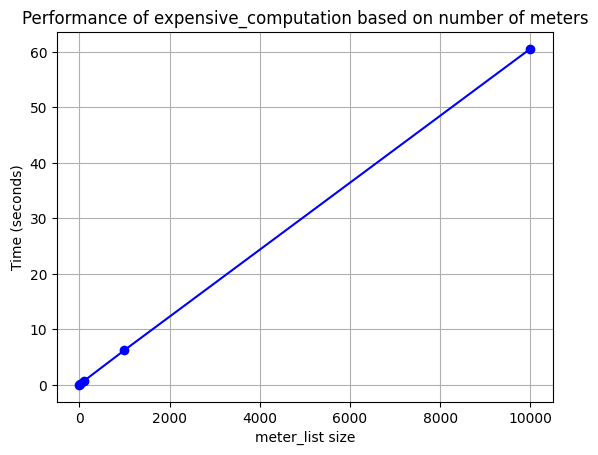

In [13]:
plt.plot(ml_len_used, time_taken, marker='o', linestyle='-', color='b')
plt.xlabel('meter_list size')
plt.ylabel('Time (seconds)')
plt.title('Performance of transpôrtation cost calculation based on number of meters')
plt.grid(True)
plt.show()


In [14]:
period_len = [1,10,100,1000,10000]
period_len_used = []
time_taken = []

for value in period_len:
    df_ml = generate_meters(10)
    df_fc = consume(df_ml['meter_id'], '2024-01-01', value)
    start_time = time.time()  # Start measuring time
    calculate_transportation_cost(df_ml,df_fc)
    end_time = time.time()  # End measuring time
    
    period_len_used.append(value)
    time_taken.append(end_time - start_time)  # Store the time taken for current value of n


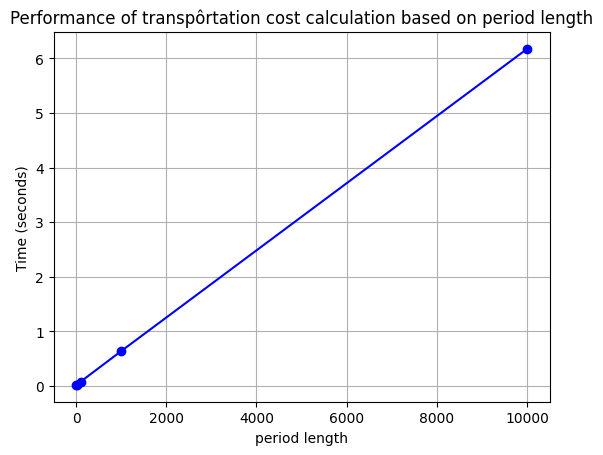

In [15]:
plt.plot(period_len_used, time_taken, marker='o', linestyle='-', color='b')
plt.xlabel('period length')
plt.ylabel('Time (seconds)')
plt.title('Performance of transpôrtation cost calculation based on period length')
plt.grid(True)
plt.show()

In [34]:
'''What are your observations after benchmarking? Are there any steps in the cost 
calculation that can be improved? How would you go about improving the performance 
of this calculation'''

print("Modifying period length hardly affects the calculation performance." + '\n' +
"Meter lists however seem to affect the transportation cost calculation way more." + '\n' +
"Length to complete increases in a linear way." + '\n' +
"The filtering step after merging with the rates df is the slowest part of the function." + '\n\n' +
"Possible improvements could be:" + '\n' +
"Remove the intermediate dataframes in the function. at the end I swith to using the summary df for example, but this could affect" + "\n" + 
"overhead memory when working with large dataframes." + "\n" +
"Find alternatives on merges especially when using large datasets" + '\n' +
"Use np.logical_and function at the point of filtering. - During my benchmarking the difference wasn't all too great.")



Modifying period length hardly affects the calculation performance.
Meter lists however seem to affect the transportation cost calculation way more.
Length to complete increases in a linear way.
The filtering step after merging with the rates df is the slowest part of the function.

Possible improvements could be:
Remove the intermediate dataframes in the function. at the end I swith to using the summary df for example, but this could affect
overhead memory when working with large dataframes.
Find alternatives on merges especially when using large datasets
Use np.logical_and function at the point of filtering. - During my benchmarking the difference wasn't all too great.
